In [2]:
import logging
import re
import sys
from os import listdir
from os.path import abspath, join

import geopandas as gpd
import geoplot as gplt
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from rasterio.features import shapes
from interviz.helpers.raster_to_polygons import disaggregate_viewsheds_and_convert_to_polygons

logging.basicConfig(stream=sys.stderr, level=logging.INFO)
logger = logging.getLogger('__name__')

% matplotlib inline

In [32]:
proj = gplt.crs.TransverseMercator()

In [3]:
%pwd

'/home/joshainglis/other_projects/papers/isea_interviz'

## Read in shapefiles

In [4]:
import os
join(os.path.abspath(os.curdir), 'data', 'ISEA')

'/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA'

In [5]:
base_path = join(os.path.abspath(os.curdir), 'data', 'ISEA', 'Full_VS')

In [6]:
data_path = join(base_path, 'sl_-85')

In [7]:
def load_viewpoints(path: str, save_path: str=None) -> gpd.GeoDataFrame:
    viewpoints = gpd.read_file(path)
    viewpoints['FID'] = viewpoints.FID_split - 1
    if save_path is not None:
        viewpoints.to_file(save_path)
    return viewpoints[['FID', 'geometry']].set_index('FID', drop=False, verify_integrity=True)

def load_islands(path: str, save_path: str=None) -> gpd.GeoDataFrame:
    islands = gpd.read_file(path)
    islands['FID'] = islands.Id - 1
    islands = islands.set_index('FID', drop=False, verify_integrity=True)
    islands.geometry = islands.buffer(0)
    if save_path is not None:
        islands.to_file(save_path)
    return islands[['geometry']]

def load_split_islands(path: str, save_path: str=None) -> gpd.GeoDataFrame:
    split_islands = gpd.read_file(path)
    split_islands['FID_island'] = split_islands.Id - 1
    if save_path is not None:
        split_islands.to_file(save_path)
    return split_islands[['FID_island']]

In [8]:
viewpoints = load_viewpoints(join(data_path, 'gridded_viewpoints.shp'))
islands = load_islands(join(data_path, 'islands.shp'), join(data_path, 'islands_fixed.shp'))
split_islands = load_split_islands(join(data_path, 'split_islands.shp'), join(data_path, 'split_islands_fixed.shp'))

In [9]:
joined_viewpoints = viewpoints.join(split_islands, how='inner')
joined_viewpoints = joined_viewpoints[['FID_island', 'geometry']]
joined_viewpoints = joined_viewpoints.reset_index()
joined_viewpoints.columns = ['FID_point', 'FID_island', 'geometry']

In [9]:
joined_viewpoints.head()

,FID_point,FID_island,geometry
0,0,300,POINT Z (121.4899644644885 22.65515209079632 180)
1,1,301,POINT Z (119.2149264016322 22.45516143245419 -78)
2,2,303,POINT Z (119.0982577833702 22.3385002156125 -31)
3,3,304,POINT Z (118.7732523458192 22.3051684393721 -69)
4,4,305,POINT Z (121.5399653007581 22.05518011756851 436)


In [10]:
island_viewpoints = joined_viewpoints.join(islands, on='FID_island', rsuffix='_island')
# island_viewpoints.to_file(join(data_path, 'island_viewpoints.shp'))

In [11]:
island_viewpoints.head()

,FID_point,FID_island,geometry,geometry_island
0,0,300,POINT Z (121.4899644644885 22.65515209079632 180),"POLYGON ((121.5024646731162 22.62894743359999,..."
1,1,301,POINT Z (119.2149264016322 22.45516143245419 -78),"POLYGON ((119.227426610728 22.43727756021207, ..."
2,2,303,POINT Z (119.0982577833702 22.3385002156125 -31),"POLYGON ((119.0774241011201 22.27894157784812,..."
3,3,304,POINT Z (118.7732523458192 22.3051684393721 -69),"POLYGON ((118.8274199184401 22.25394115958011,..."
4,4,305,POINT Z (121.5399653007581 22.05518011756851 436),"POLYGON ((121.6024663461881 21.99560350414407,..."


### Validate that we've mapped the viewpoint ids to the island ids correctly

In [38]:
island_viewpoints.apply(lambda row: row['geometry_island'].contains(row['geometry']), axis=1).all()

True

### Quickly plot the data to ensure it looks correct

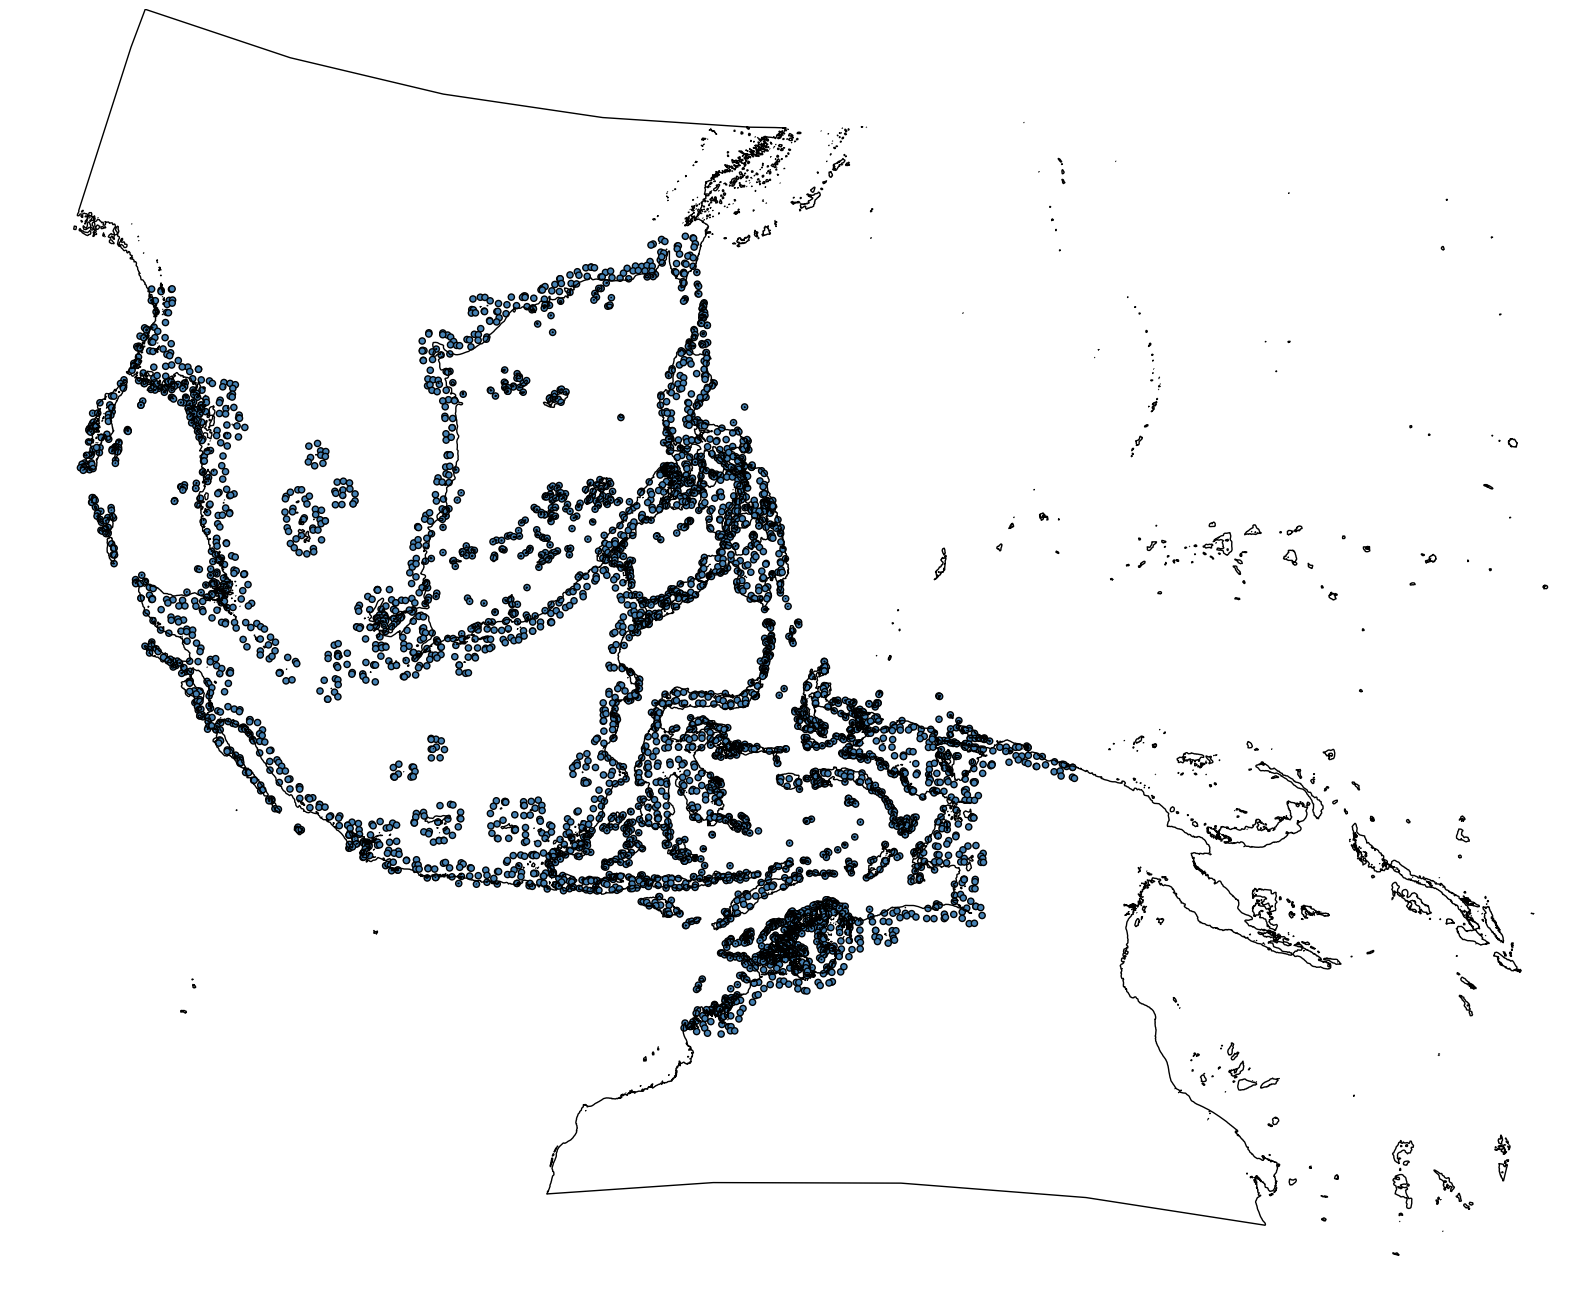

In [48]:
projection = gplt.crs.TransverseMercator()
ax = gplt.polyplot(islands, projection=projection, figsize=(20,20))
gplt.pointplot(island_viewpoints.geometry, ax=ax, projection=projection)
plt.show()

In [11]:
vs_re = re.compile(r'^viewshed_(\d{4})$')
folder = join(data_path, 'viewsheds/')
output_to = abspath(join(base_path, 'viewshed_polygons.shp'))

In [52]:
for viewshed_file in sorted(y for y in listdir(folder) if vs_re.match(y)):
    vs_num = int(vs_re.match(viewshed_file).group(1))
    raster_file = join(folder, viewshed_file)
    try:
        disaggregate_viewsheds_and_convert_to_polygons(raster_file, output_to, island_viewpoints, vs_num, use_windowing=False)
    except IndexError:
        continue

INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0001
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0002
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0003
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0004
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0005
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewshed_0006
INFO:interviz.helpers.raster_to_polygons:/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85/viewsheds/viewsh

KeyboardInterrupt: 

In [54]:
poly_viewsheds = gpd.read_file(output_to)
poly_viewsheds['geometry'] = poly_viewsheds.buffer(0)
poly_viewsheds = poly_viewsheds.dissolve(by='FID_island')
poly_viewsheds['area'] = poly_viewsheds.geometry.area
poly_viewsheds_tmp = poly_viewsheds.geometry
poly_viewsheds_tmp.crs = {'init': 'epsg:4326'}
poly_viewsheds.geometry = poly_viewsheds_tmp.buffer(0)
poly_viewsheds = poly_viewsheds.reset_index()
poly_viewsheds.to_file(join(base_path, 'poly_viewsheds_dissolved.shp'))

In [12]:
poly_viewsheds = gpd.read_file(join(base_path, 'poly_viewsheds_dissolved.shp'))

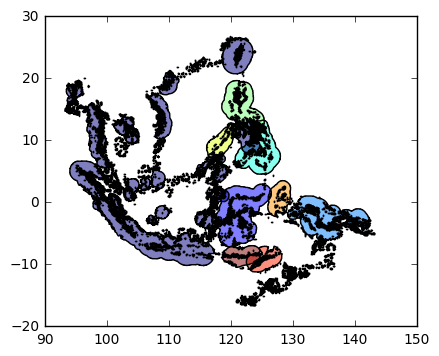

In [55]:
poly_viewsheds.sort_values(by='area', ascending=False).head(10).plot()

In [60]:
poly_viewsheds.reset_index().head()

,FID_island,geometry,FID_point,raster_val,area
0,300,"(POLYGON ((120.858813153646 22.059346589708, 1...",0,1,1.133089
1,301,"(POLYGON ((121.033804979095 23.467614137369, 1...",1,1,0.088186
2,303,"(POLYGON ((121.083802643509 23.634273018749, 1...",2,1,0.178386
3,304,"(POLYGON ((119.042231346604 22.384331408399, 1...",3,1,0.039996
4,305,"(POLYGON ((120.842147265508 22.70931622709, 12...",4,1,2.180699


In [16]:
poly_viewsheds = gpd.read_file(join(base_path, 'poly_viewsheds_dissolved.shp'))
islands = gpd.read_file(join(data_path, 'islands_fixed.shp'))
r = gpd.sjoin(islands, poly_viewsheds, lsuffix='_islands', rsuffix='_viewsheds')
r.to_file('data/sl_-85/poly_viewsheds_joined.shp')

In [7]:
data_path

'/home/joshainglis/other_projects/papers/isea_interviz/data/ISEA/Full_VS/sl_-85'

```bash
interviz-spatial-join data/ISEA/Full_VS/sl_-85/islands_fixed.shp data/ISEA/Full_VS/sl_-85/poly_viewsheds_dissolved.shp data/ISEA/Full_VS/sl_-85/poly_viewsheds_joined.shp
```

In [13]:
r = gpd.read_file(join(base_path, 'poly_viewsheds_joined.shp'))[['FID_island', 'Id', 'geometry']]
r['to_island'] = r.Id - 1
r = r[['FID_island', 'to_island']]
r.columns = ['from_island', 'to_island']
r = r[r.from_island != r.to_island]

In [14]:
r.head()

,from_island,to_island
0,1919,198
1,1919,200
2,1919,203
3,1919,205
4,1919,206


In [16]:
r.from_island.max(), r.from_island.min()

(2591, 300)

In [97]:
r.to_island.max(), r.to_island.min()

(2591, 198)

In [17]:
# r['idx_island'] = r.Id - 1
# r['idx_viewshed'] = r.index_righ
# r_unique = r[r.idx_island != r.idx_viewshed]
# r_unique = r_unique.reset_index().set_index(['idx_viewshed', 'idx_island'])
# x = list({row[0] for i, row in r_unique.reset_index().iterrows()})

In [18]:
poly_viewsheds = poly_viewsheds.set_index('FID_island')

In [19]:
islands.geometry = islands.buffer(0)
poly_viewsheds.geometry = poly_viewsheds.buffer(0)

G = nx.DiGraph()
for idx, (i, row) in enumerate(r.iterrows()):
    if i % 500 == 0:
        print(i)
    intersect = poly_viewsheds.loc[row['from_island']].geometry.intersection(islands.loc[row['to_island']].geometry)
    G.add_edge(row['from_island'], row['to_island'], area=intersect.area, region=intersect)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6500
7000
8000
8500
9000
9500
10500
11000
11500
12000
12500


In [20]:
GG = nx.DiGraph()
for node_a, node_b in G.edges_iter():
    if node_a in G.edge[node_b]:
        region = G.edge[node_a][node_b]['region']
        if not region.is_empty:
            GG.add_edge((node_a, node_b), (node_b, node_a))
            cab = region.centroid
            GG.node[(node_a, node_b)]['coord'] = (cab.x, cab.y)

In [21]:
pos = {node: GG.node[node]['coord'] for node in GG.nodes_iter() if 'coord' in GG.node[node]}

In [23]:
sum(1 for _, _, d in G.edges_iter(data=True) if d['region'].is_empty)

0

In [24]:
GG.size()

10156

In [25]:
g = gpd.GeoDataFrame([
    {
        'idx_a': node_a,
        'idx_b': node_b,
        'geometry': G[node_a][node_b]['region']
    } for node_a, node_b in GG.nodes_iter()
], geometry='geometry', crs=islands.crs)

In [26]:
g.crs

{'init': 'epsg:4326'}

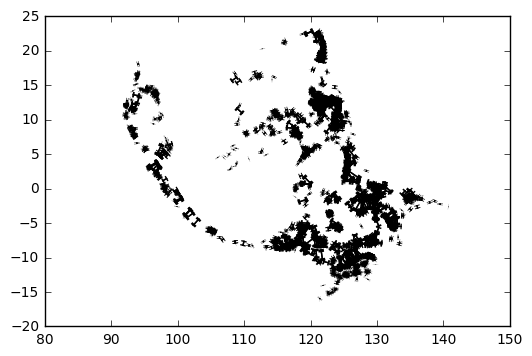

In [27]:
nx.draw_networkx_edges(GG, pos=pos)

In [24]:
rr = r_unique[['index_right']]

In [72]:
r_unique['geometry'] = r_unique.apply(lambda row: G[row.name[0]][row.name[1]]['region'], axis=1)

ValueError: Shape of passed values is (14782, 4), indices imply (14782, 5)

In [87]:
r_unique = r_unique[['geometry']].apply(lambda row: (G[row.name[0]][row.name[1]]['region'],), axis=1)

In [39]:
rr = gpd.GeoDataFrame(rr)

In [28]:
for node in G.nodes_iter():
    c = r_unique.loc[node].geometry.centroid
    G.node[node]['coord'] = (c.x, c.y)
for node_a, node_b in G.edges_iter()
    

14783

In [29]:
pos = {node: G.node[node]['coord'] for node in G.nodes_iter()}

In [28]:
gg = g.set_index(['idx_a', 'idx_b']).buffer(0)

In [29]:
gg[gg.apply(lambda x: x.is_valid and not x.is_empty and x.area > 1e-9)].area.sort_values(ascending=True)

idx_a  idx_b
2190   2227     5.754630e-09
1744   1741     1.684338e-08
1660   1508     3.403500e-08
1357   1349     9.689502e-08
1511   1512     1.781890e-07
2117   2137     2.310873e-07
1999   2000     2.629134e-07
1515   1507     3.225592e-07
2244   2205     3.517323e-07
1100   1099     4.108756e-07
1919   1099     4.108756e-07
2235   2259     5.660396e-07
1715   1716     7.505498e-07
2591   2372     7.951886e-07
2094   2086     8.109385e-07
1730   1689     8.832120e-07
1727   1689     8.832120e-07
571    599      9.107432e-07
1252   1256     1.051494e-06
2098   2120     1.119334e-06
2117   2127     1.123841e-06
1227   1225     1.172870e-06
1226   1225     1.172870e-06
1865   1890     1.213015e-06
1095   1094     1.294692e-06
1260   1279     1.301657e-06
2344   2345     1.330141e-06
1919   464      1.391112e-06
2255   2236     1.406369e-06
2389   2392     1.693421e-06
                    ...     
1660   1432     3.977129e-01
572    632      4.132718e-01
1659   1919     4.235997e-01
6

In [30]:
x = gg[gg.apply(lambda x: not x.is_empty and x.area > 1e-9 and x.is_valid)]
xa = gpd.GeoDataFrame(x.centroid, geometry=0, crs=islands.crs)
xa.columns = ['geometry']
xa_tmp = xa.reset_index()
xa_tmp['idx'] = xa_tmp.apply(lambda y: (y.idx_a, y.idx_b), axis=1)
xa_tmp['idx_other'] = xa_tmp.apply(lambda y: (y.idx_b, y.idx_a), axis=1)
xa_tmp = xa_tmp.set_index('idx')
paths = xa_tmp.join(xa_tmp, on='idx_other', lsuffix='_ab', rsuffix='_ba')
paths = paths[paths.apply(lambda y: y.geometry_ab is not np.nan and y.geometry_ba is not np.nan, axis=1)]

In [ ]:
x[x.area == x.area.max()]

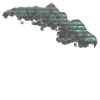

In [208]:
x.loc[(66, 181)]

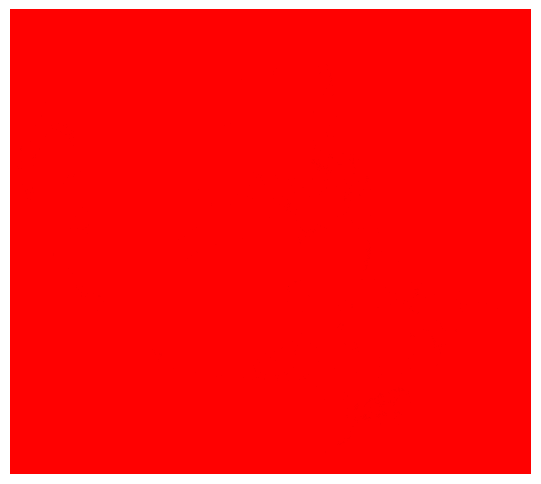

In [33]:
gplt.polyplot(
    x.simplify(2), 
    projection=proj, 
    linewidth=0, 
    facecolor='red', 
    alpha=0.3
)


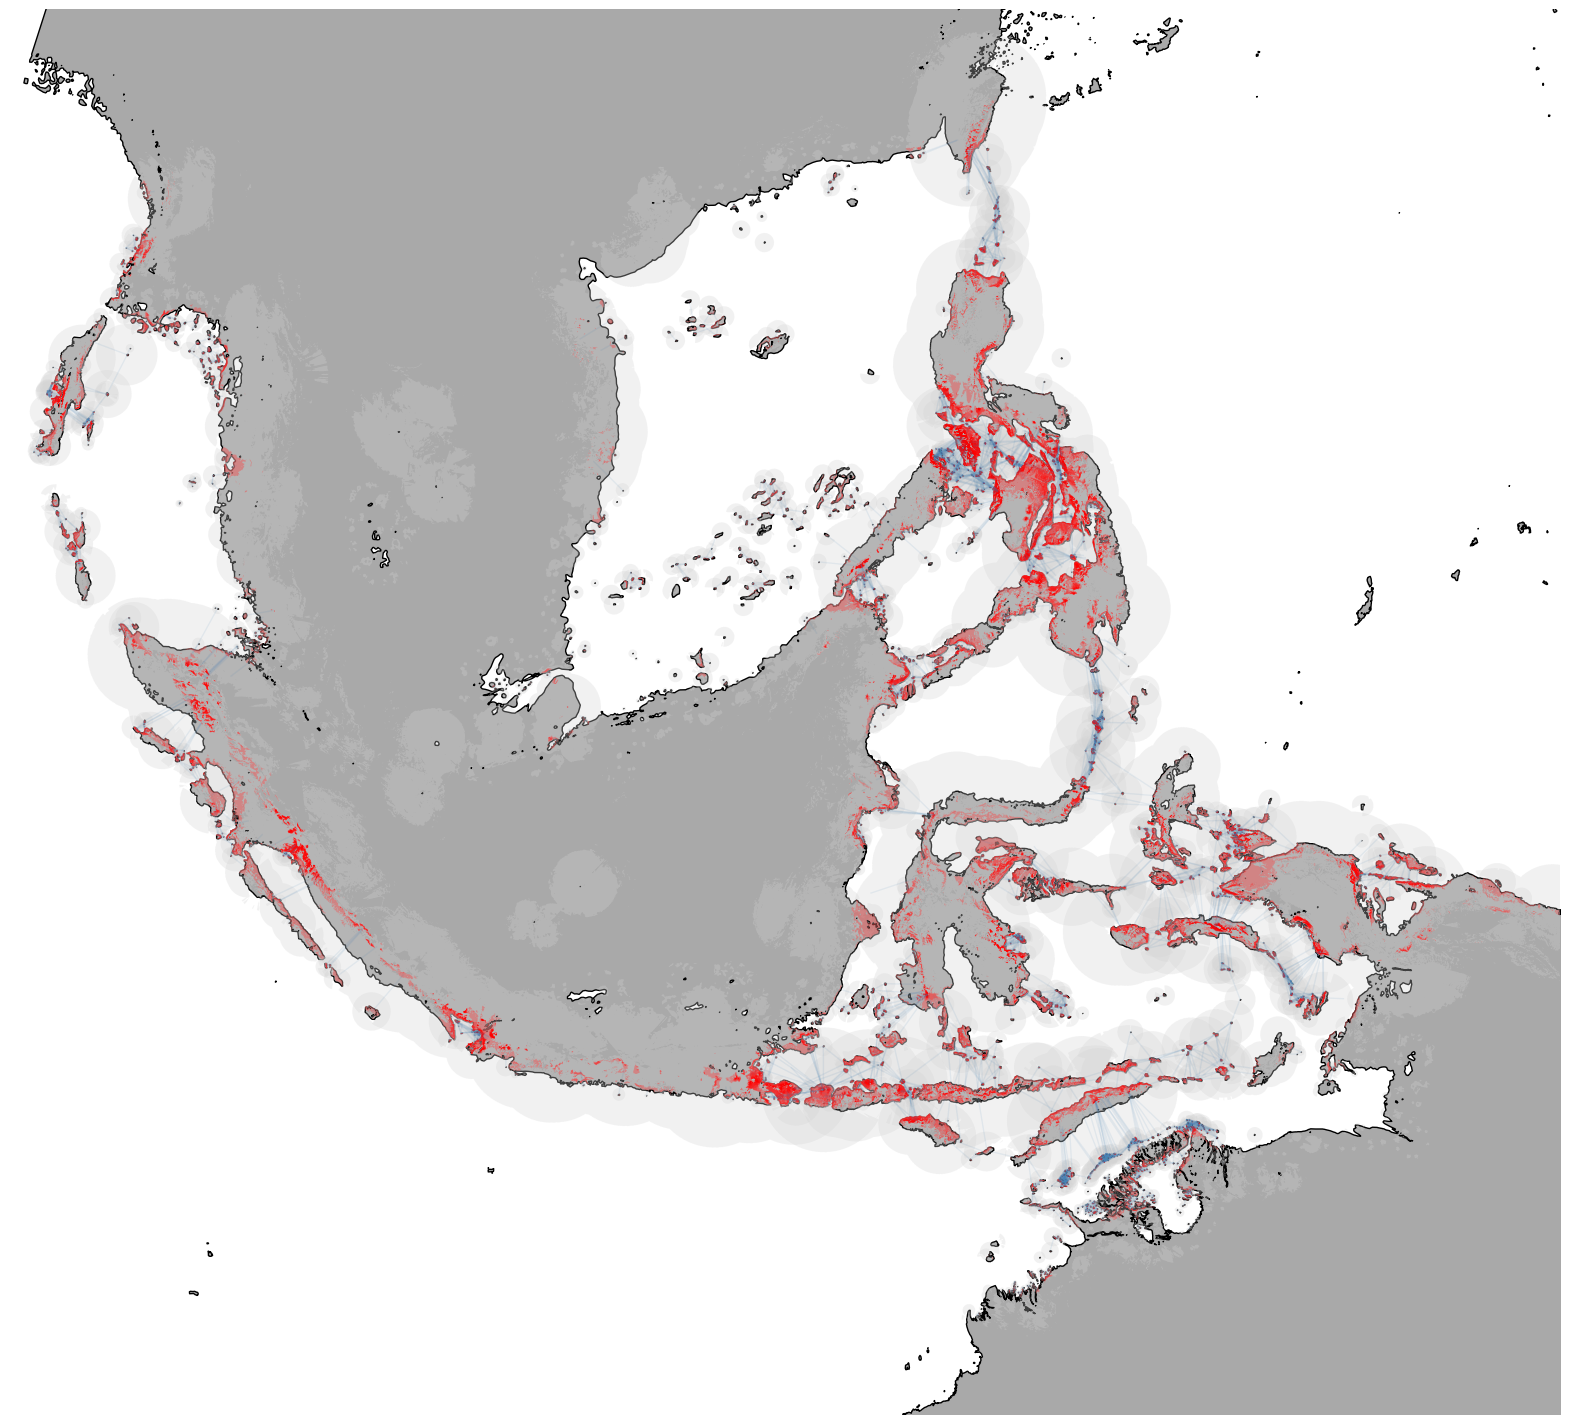

In [34]:
proj = gplt.crs.TransverseMercator()
ax = gplt.polyplot(
    islands, 
    projection=proj, 
    figsize=(20, 20), 
    color='darkgray'
)
gplt.polyplot(
    poly_viewsheds, 
    projection=proj, 
    ax=ax, 
    linewidth=0, 
    facecolor='lightgray', 
    alpha=0.3
)
gplt.polyplot(
    x, 
    projection=proj, 
    ax=ax, 
    linewidth=0, 
    facecolor='red', 
    alpha=0.3
)
gplt.sankey(
    paths, 
    start='geometry_ab', 
    end='geometry_ba', 
    ax=ax, 
    projection=proj, 
    alpha=0.05,
    rasterized=False
)


plt.savefig('isea_interviz.pdf')
plt.show()

In [ ]:
plt.plot()

In [ ]:
x = gg[gg.apply(lambda x: not x.is_empty and x.area > 1e-9)]
xa = gpd.GeoDataFrame(x.centroid, geometry=0, crs=islands.crs)
xa.columns = ['geometry']
xa_tmp = xa.reset_index()
xa_tmp['idx'] = xa_tmp.apply(lambda y: (y.idx_a, y.idx_b), axis=1)
xa_tmp['idx_other'] = xa_tmp.apply(lambda y: (y.idx_b, y.idx_a), axis=1)
xa_tmp = xa_tmp.set_index('idx')
paths = xa_tmp.join(xa_tmp, on='idx_other', lsuffix='_ab', rsuffix='_ba')
paths = paths[paths.apply(lambda y: y.geometry_ab is not np.nan and y.geometry_ba is not np.nan, axis=1)]

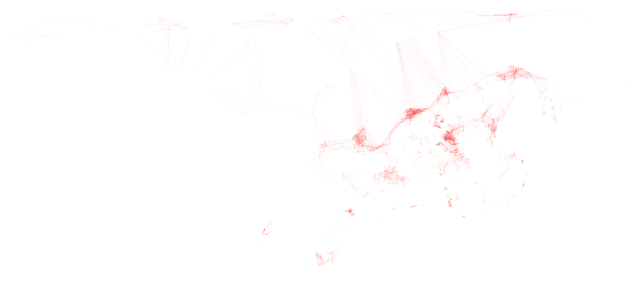

In [205]:
gplt.sankey(
    paths, 
    start='geometry_ab', 
    end='geometry_ba', 
#     ax=ax, 
    projection=proj, 
    alpha=0.01,
    color='red'
)

In [118]:
gg[gg.apply(lambda x: not x.is_empty)]

idx_a  idx_b
927    902      (POLYGON ((125.285235898502 -12.440893901035, ...
437    406      POLYGON ((126.507735898502 -11.03187986199528,...
43     3        POLYGON ((122.132735898502 -8.108393901034999,...
104    115      POLYGON ((128.3352358985021 -9.915893901034963...
1246   1247     (POLYGON ((123.3094054544428 -14.790893901035,...
124    110      (POLYGON ((129.2737866447615 -9.880893901035, ...
968    988      POLYGON ((125.4827358985023 -12.73589390103501...
678    667      POLYGON ((125.277735898502 -11.65359520212925,...
347    393      POLYGON ((128.102735898502 -11.000893901035, 1...
1032   1029     POLYGON ((124.6938314795568 -12.955893901035, ...
647    660      (POLYGON ((126.705235898502 -11.640893901035, ...
321    278      (POLYGON ((125.822735898502 -10.7096108872868,...
543    583      POLYGON ((126.950235898502 -11.50089390103473,...
967    891      POLYGON ((125.472735898502 -12.405893901035, 1...
898    938      POLYGON ((125.130235898502 -12.5356658874449, .

In [108]:
for x in gg:
    if x.is_empty:
        print(x)


POLYGON EMPTY
POLYGON EMPTY


In [153]:
rc = r_unique.copy()
rc['from'] = r_unique.centroid.loc[f]
rc['to'] = r_unique.centroid.loc[b].apply(lambda row: (row,))

In [152]:
rc = rc.to

In [140]:
rc.loc[b].head()

geometry
index_right index                                              
0           32     POINT (125.6042419059899 -8.216693859646917)
            59     POINT (125.0068434661167 -8.222921994796517)
            189     POINT (126.023752371104 -8.590301661496985)
1           28     POINT (128.9734510783919 -8.212909551607369)
            20     POINT (128.7399000631915 -8.178440180158013)

In [1]:
# ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
# gplt.polyplot(y, projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)
gplt.sankey(start=rc['from'], end=rc['to'], projection=gplt.crs.TransverseMercator(), alpha=0.4)

NameError: name 'gplt' is not defined

FID
0       POINT (125.7619418607224 -8.022246080170657)
0       POINT (125.7619418607224 -8.022246080170657)
0       POINT (125.7619418607224 -8.022246080170657)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
1       POINT (129.7381903495972 -8.029839325095688)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
2        POINT (127.183450787513 -8.064602888323758)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392337903608)
3       POINT (122.1227112405105 -8.117392

In [177]:
islands.iloc[0].geometry.centroid.y

-8.022246080170657

In [167]:
row[1]

1276

In [172]:
y.ix[row[1]]

geometry      (POLYGON ((123.570235898502 -14.920893901035, ...
FID_point                                                  1486
raster_val                                                    1
Name: 1276, dtype: object

In [166]:
row[1]
y.iloc[row[1]]
islands.iloc[row[0]].geometry

IndexError: single positional indexer is out-of-bounds

In [163]:
row

index            72
index_right    1276
Name: 1400, dtype: int64

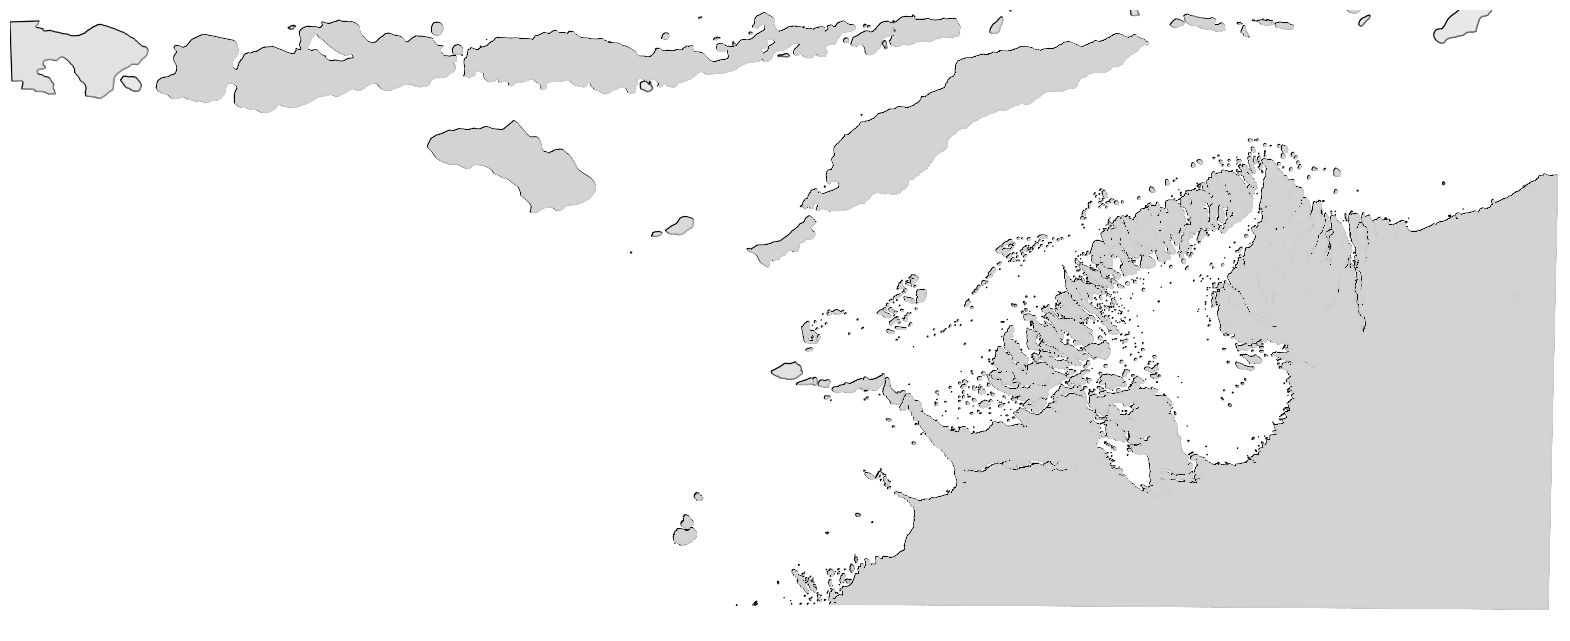

In [103]:
ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
gplt.polyplot(r_unique, projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)

In [130]:
islands['geometry'] = islands.buffer(0)

In [143]:
islands.shape

(1277, 3)

In [144]:
y.shape

(1268, 3)

In [129]:
intersected = y.intersection(islands.buffer(0))

0       POLYGON ((125.760235898502 -8.039592896254529,...
1       (POLYGON ((129.760235898502 -8.043393901034998...
2       (POLYGON ((127.175235898502 -8.103393901035, 1...
3       POLYGON ((122.110235898502 -8.125045589614972,...
4       POLYGON ((124.6212182209325 -8.123393901034998...
5       POLYGON ((128.6827358985021 -8.15089390103492,...
6       POLYGON ((128.6827358985021 -8.15089390103492,...
7       POLYGON ((128.5627358985022 -8.160893901034967...
8       POLYGON ((128.7502358985022 -8.160893901034967...
9       (POLYGON ((128.5627358985023 -8.16089390103499...
10      (POLYGON ((128.7409435180143 -8.16089390103499...
11      (POLYGON ((128.7527358985021 -8.16089390103499...
12      (POLYGON ((128.5792836205527 -8.16089390103499...
13      POLYGON ((128.5845722986948 -8.165893901035, 1...
14      (POLYGON ((117.363935340719 -8.165893901035, 1...
15      POLYGON ((124.370235898502 -8.170893901034999,...
16      POLYGON ((128.3879314117754 -8.190893901034999...
17      (POLYG

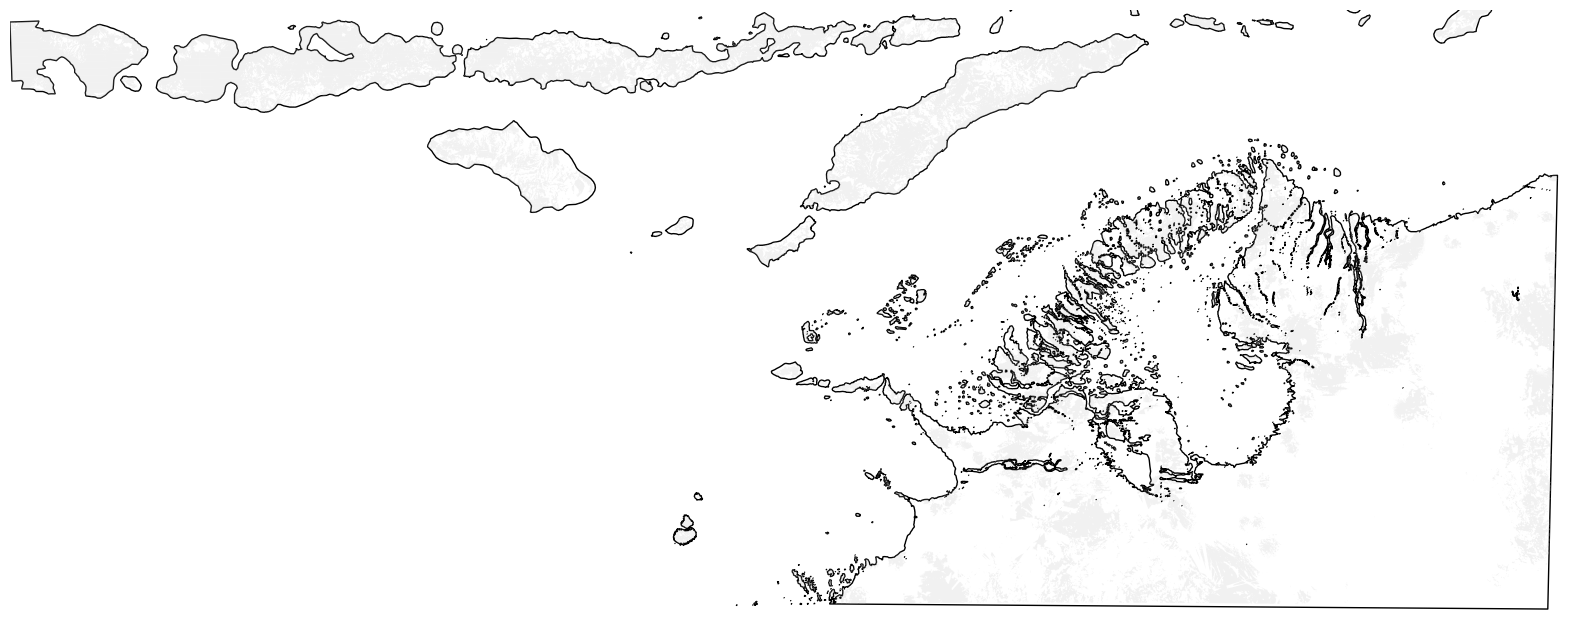

In [142]:
ax = gplt.polyplot(islands, projection=gplt.crs.TransverseMercator(), figsize=(20, 20))
gplt.polyplot(intersected[intersected.area > 0].buffer(0), projection=gplt.crs.TransverseMercator(), ax=ax, linewidth=0, facecolor='lightgray', alpha=0.3)